In [104]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from conllu import parse
import nltk
from nltk.tokenize import word_tokenize
import string

In [28]:
with open("UD_English-Atis/en_atis-ud-train.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    train_sentences = parse(data)
    
with open("UD_English-Atis/en_atis-ud-dev.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    dev_sentences = parse(data)
    
with open("UD_English-Atis/en_atis-ud-test.conllu", "r", encoding="utf-8") as f:
    data = f.read()
    test_sentences = parse(data)
    
tokens = []
for sentence in train_sentences:
    for token in sentence:
        tokens.append(token)

In [29]:
df = pd.DataFrame(tokens)

In [30]:
pos_class = {token: idx for idx, token in enumerate(df['upos'].unique())}
pos_class_rev = {idx: token for idx, token in enumerate(df['upos'].unique())}
pos_class['<SPECIAL>'] = len(pos_class)
vocab = df['form'].unique()
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
vocab = np.append(vocab, [START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
vocab = {token: idx for idx, token in enumerate(vocab)}

In [102]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.max_len = np.max([len(sentence) for sentence in self.data])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sentence =[vocab[START_TOKEN]] + [vocab[token['form']] if token['form'] in vocab else vocab[UNKNOWN_TOKEN] for token in self.data[idx]]
        sentence += [vocab[END_TOKEN]] + [vocab[PAD_TOKEN] for _ in range(self.max_len - len(self.data[idx]))]
        labels = [pos_class['<SPECIAL>']] + [pos_class[token['upos']] if token['upos'] in pos_class else pos_class['<SPECIAL>'] for token in self.data[idx]] + [pos_class['<SPECIAL>']] + [pos_class['<SPECIAL>'] for _ in range(self.max_len - len(self.data[idx]))]
        return torch.tensor(sentence), torch.tensor(labels)
        
        
def tokenize(input_sentence):
    tokens = word_tokenize(input_sentence)
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    test_tokens = [vocab[START_TOKEN]] + [vocab[token] if token in vocab else vocab[UNKNOWN_TOKEN] for token in tokens]+ [vocab[END_TOKEN]]
    return torch.tensor(test_tokens)

In [79]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, output_dim,activation = 'relu', classification_dim = 64, rnn_type='rnn', bidirectionality = False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim,padding_idx= vocab[PAD_TOKEN])
        if rnn_type == 'rnn':
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional = bidirectionality)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional = bidirectionality)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional = bidirectionality)
        self.fc1 = nn.Linear((bidirectionality+1)*hidden_dim, classification_dim)
        self.fc2 = nn.Linear(classification_dim, output_dim)
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Tanh()
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc2(self.act(self.fc1(output)))
        return output
    
    def predict(self, x):
        out = self.forward(x)
        return torch.argmax(self.softmax(out), axis = 2)

In [82]:
num_epochs = 10
embedding_dims = 100
bidirectionality = [True, False]
num_layers = [1,2]
hidden_dims = [64, 128]
classification_dim = [64, 128]
activations = ['relu', 'tanh']
params_acc = []

train_data = CustomDataset(train_sentences)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_data = CustomDataset(dev_sentences)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

for bidirectional in bidirectionality:    
    for idx,layers in enumerate(num_layers):
        for act_idx, activation in enumerate(activations):
            for hidden_dim in hidden_dims:
                for class_dim in classification_dim:
                    model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1,activation = activation, classification_dim = class_dim, rnn_type = 'rnn', bidirectionality = bidirectional)
                    loss_function = nn.CrossEntropyLoss(ignore_index = pos_class['<SPECIAL>'])
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                    model.train()
                    best_acc = 0
                    for epoch in range(num_epochs):
                        net_loss = 0
                        for x, y in train_loader:
                            optimizer.zero_grad()
                            output = model(x)
                            output = torch.transpose(output, 1,2)
                            loss = loss_function(output, y)
                            loss.backward()
                            net_loss += loss
                            optimizer.step()

                        with torch.no_grad():
                            accuracy = 0
                            for x, y in dev_loader:
                                predict = model.predict(x).reshape(-1)
                                y = y.reshape(-1)
                                seq_index = y != pos_class['<SPECIAL>']
                                y = y[seq_index]
                                predict = predict[seq_index]
                                accuracy += (len(predict[predict == y])) / len(predict)
                        if accuracy > best_acc:
                            best_acc = accuracy
                            torch.save(model.state_dict(), f'./RNN/model_{bidirectional}_{layers}_{activation}_{hidden_dim}_{class_dim}.pth')

                        print(f"TRAIN [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Loss: {net_loss.item() / len(train_loader):.4f}")
                        print(f"DEV [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Accuracy: {accuracy / len(dev_loader):.4f}")
                    print('\n')
                    params_acc.append(['rnn', bidirectional, layers, hidden_dim, activation, class_dim, best_acc / len(dev_loader)])
                

TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.8155
DEV [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9407
TRAIN [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.1560
DEV [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9633
TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0914
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9754
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0663
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9737
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 

TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0311
DEV [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9798
TRAIN [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0270
DEV [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9781
TRAIN [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0257
DEV [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9765
TRAIN [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0226
DEV [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9809


TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_di

TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0754
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9779
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0569
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9765
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0450
DEV [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9786
TRAIN [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0366
DEV [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9779
TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim:

TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0240
DEV [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9754
TRAIN [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0214
DEV [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9788


TRAIN [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.4634
DEV [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9613
TRAIN [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.1051
DEV [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9743
TRAIN [2 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 1

TRAIN [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0427
DEV [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9774
TRAIN [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0351
DEV [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9781
TRAIN [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0300
DEV [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9788
TRAIN [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0263
DEV [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9780
TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Cl

TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.7988
DEV [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9208
TRAIN [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1826
DEV [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9531
TRAIN [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1154
DEV [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9633
TRAIN [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0902
DEV [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9696
TRAIN [4 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim

TRAIN [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0616
DEV [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9698
TRAIN [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0571
DEV [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9720
TRAIN [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0530
DEV [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9732
TRAIN [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0502
DEV [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9724


TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_d

TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.1151
DEV [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9651
TRAIN [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0888
DEV [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9684
TRAIN [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0741
DEV [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9642
TRAIN [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0649
DEV [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9668
TRAIN [6 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim

TRAIN [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0540
DEV [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9702
TRAIN [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0509
DEV [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9715


TRAIN [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.7952
DEV [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9288
TRAIN [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.1888
DEV [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9527
TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 

In [83]:
num_epochs = 10
embedding_dims = 100
bidirectionality = [True, False]
num_layers = [1,2]
hidden_dims = [64, 128]
classification_dim = [64, 128]
activations = ['relu', 'tanh']

train_data = CustomDataset(train_sentences)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_data = CustomDataset(dev_sentences)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

for bidirectional in bidirectionality:    
    for idx,layers in enumerate(num_layers):
        for act_idx, activation in enumerate(activations):
            for hidden_dim in hidden_dims:
                for class_dim in classification_dim:
                    model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1,activation = activation, classification_dim = class_dim, rnn_type = 'gru', bidirectionality = bidirectional)
                    loss_function = nn.CrossEntropyLoss(ignore_index = pos_class['<SPECIAL>'])
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                    model.train()
                    best_acc = 0
                    for epoch in range(num_epochs):
                        net_loss = 0
                        for x, y in train_loader:
                            optimizer.zero_grad()
                            output = model(x)
                            output = torch.transpose(output, 1,2)
                            loss = loss_function(output, y)
                            loss.backward()
                            net_loss += loss
                            optimizer.step()

                        with torch.no_grad():
                            accuracy = 0
                            for x, y in dev_loader:
                                predict = model.predict(x).reshape(-1)
                                y = y.reshape(-1)
                                seq_index = y != pos_class['<SPECIAL>']
                                y = y[seq_index]
                                predict = predict[seq_index]
                                accuracy += (len(predict[predict == y])) / len(predict)
                        if accuracy > best_acc:
                            best_acc = accuracy
                            torch.save(model.state_dict(), f'./GRU/model_{bidirectional}_{layers}_{activation}_{hidden_dim}_{class_dim}.pth')

                        print(f"TRAIN [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Loss: {net_loss.item() / len(train_loader):.4f}")
                        print(f"DEV [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Accuracy: {accuracy / len(dev_loader):.4f}")
                    print('\n')
                    params_acc.append(['gru', bidirectional, layers, hidden_dim, activation, class_dim, best_acc / len(dev_loader)])
                

TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.9112
DEV [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9459
TRAIN [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.1417
DEV [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9740
TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0769
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9753
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0556
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9806
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 

TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0275
DEV [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9819
TRAIN [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0263
DEV [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9829
TRAIN [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0234
DEV [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9823
TRAIN [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0213
DEV [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9757


TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_di

TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0628
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9825
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0446
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9826
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0362
DEV [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9822
TRAIN [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0297
DEV [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9817
TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim:

TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0214
DEV [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9789
TRAIN [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0209
DEV [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9809


TRAIN [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.5947
DEV [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9633
TRAIN [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0963
DEV [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9785
TRAIN [2 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 1

TRAIN [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0372
DEV [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9804
TRAIN [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0307
DEV [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9810
TRAIN [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0275
DEV [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9800
TRAIN [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0257
DEV [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9805
TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Cl

TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.8355
DEV [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9377
TRAIN [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1652
DEV [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9546
TRAIN [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1024
DEV [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9706
TRAIN [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0785
DEV [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9714
TRAIN [4 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim

TRAIN [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0535
DEV [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9669
TRAIN [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0501
DEV [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9714
TRAIN [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0462
DEV [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9714
TRAIN [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0459
DEV [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9702


TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_d

TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.1032
DEV [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9679
TRAIN [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0774
DEV [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9693
TRAIN [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0661
DEV [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9704
TRAIN [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0575
DEV [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9647
TRAIN [6 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim

TRAIN [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0488
DEV [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9702
TRAIN [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0468
DEV [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9711


TRAIN [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 1.0179
DEV [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9202
TRAIN [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.1901
DEV [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9602
TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 

In [84]:
num_epochs = 10
embedding_dims = 100
bidirectionality = [True, False]
num_layers = [1,2]
hidden_dims = [64, 128]
classification_dim = [64, 128]
activations = ['relu', 'tanh']

train_data = CustomDataset(train_sentences)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_data = CustomDataset(dev_sentences)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

for bidirectional in bidirectionality:    
    for idx,layers in enumerate(num_layers):
        for act_idx, activation in enumerate(activations):
            for hidden_dim in hidden_dims:
                for class_dim in classification_dim:
                    model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1,activation = activation, classification_dim = class_dim, rnn_type = 'lstm', bidirectionality = bidirectional)
                    loss_function = nn.CrossEntropyLoss(ignore_index = pos_class['<SPECIAL>'])
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                    model.train()
                    best_acc = 0
                    for epoch in range(num_epochs):
                        net_loss = 0
                        for x, y in train_loader:
                            optimizer.zero_grad()
                            output = model(x)
                            output = torch.transpose(output, 1,2)
                            loss = loss_function(output, y)
                            loss.backward()
                            net_loss += loss
                            optimizer.step()

                        with torch.no_grad():
                            accuracy = 0
                            for x, y in dev_loader:
                                predict = model.predict(x).reshape(-1)
                                y = y.reshape(-1)
                                seq_index = y != pos_class['<SPECIAL>']
                                y = y[seq_index]
                                predict = predict[seq_index]
                                accuracy += (len(predict[predict == y])) / len(predict)
                        if accuracy > best_acc:
                            best_acc = accuracy
                            torch.save(model.state_dict(), f'./LSTM/model_{bidirectional}_{layers}_{activation}_{hidden_dim}_{class_dim}.pth')

                        print(f"TRAIN [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Loss: {net_loss.item() / len(train_loader):.4f}")
                        print(f"DEV [{epoch} | {num_epochs}] bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim} Accuracy: {accuracy / len(dev_loader):.4f}")
                    print('\n')
                    params_acc.append(['lstm', bidirectional, layers, hidden_dim, activation, class_dim, best_acc / len(dev_loader)])
                

TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.9868
DEV [0 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9406
TRAIN [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.1439
DEV [1 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9733
TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0774
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9772
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Loss: 0.0555
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9802
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 64, Class_dim: 

TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0260
DEV [6 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9797
TRAIN [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0234
DEV [7 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9787
TRAIN [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0212
DEV [8 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9815
TRAIN [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.0180
DEV [9 | 10] bidirectional: True, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9784


TRAIN [0 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_di

TRAIN [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0608
DEV [2 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9822
TRAIN [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0432
DEV [3 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9803
TRAIN [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0336
DEV [4 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9782
TRAIN [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Loss: 0.0283
DEV [5 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9813
TRAIN [6 | 10] bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim:

TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0202
DEV [8 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9802
TRAIN [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0195
DEV [9 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9791


TRAIN [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.8627
DEV [0 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9560
TRAIN [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Loss: 0.1061
DEV [1 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 128, Class_dim: 128 Accuracy: 0.9789
TRAIN [2 | 10] bidirectional: True, num_layers: 2, Activation: relu, hidden_dim: 1

TRAIN [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0351
DEV [4 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9822
TRAIN [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0318
DEV [5 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9810
TRAIN [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0277
DEV [6 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9827
TRAIN [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Loss: 0.0242
DEV [7 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9801
TRAIN [8 | 10] bidirectional: True, num_layers: 2, Activation: tanh, hidden_dim: 128, Cl

TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.9675
DEV [0 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9287
TRAIN [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1793
DEV [1 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9588
TRAIN [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.1055
DEV [2 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9685
TRAIN [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Loss: 0.0790
DEV [3 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim: 128, Class_dim: 64 Accuracy: 0.9668
TRAIN [4 | 10] bidirectional: False, num_layers: 1, Activation: relu, hidden_dim

TRAIN [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0510
DEV [6 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9730
TRAIN [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0477
DEV [7 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9717
TRAIN [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0461
DEV [8 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9713
TRAIN [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.0436
DEV [9 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9728


TRAIN [0 | 10] bidirectional: False, num_layers: 1, Activation: tanh, hidden_d

TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.1162
DEV [2 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9594
TRAIN [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0816
DEV [3 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9702
TRAIN [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0652
DEV [4 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9612
TRAIN [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Loss: 0.0587
DEV [5 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9722
TRAIN [6 | 10] bidirectional: False, num_layers: 2, Activation: relu, hidden_dim

TRAIN [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0500
DEV [8 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9700
TRAIN [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Loss: 0.0473
DEV [9 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 64 Accuracy: 0.9685


TRAIN [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 1.3107
DEV [0 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.8784
TRAIN [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Loss: 0.2422
DEV [1 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 64, Class_dim: 128 Accuracy: 0.9603
TRAIN [2 | 10] bidirectional: False, num_layers: 2, Activation: tanh, hidden_dim: 

In [85]:
dev_performance = pd.DataFrame(params_acc, columns = ['Model','Bidirectionality', 'Num Layers', 'Hidden dims', 'Activation','Classification dim', 'Accuracy']).sort_values('Accuracy', ascending = False)
dev_performance

,Model,Bidirectionality,Num Layers,Hidden dims,Activation,Classification dim,Accuracy
39,gru,True,1,128,tanh,128,0.984657
68,lstm,True,1,64,tanh,64,0.984607
1,rnn,True,1,64,relu,128,0.984299
70,lstm,True,1,128,tanh,64,0.983812
38,gru,True,1,128,tanh,64,0.983732
...,...,...,...,...,...,...,...
91,lstm,False,2,128,relu,128,0.970892
27,rnn,False,2,128,relu,128,0.970571
92,lstm,False,2,64,tanh,64,0.969969
26,rnn,False,2,128,relu,64,0.969948


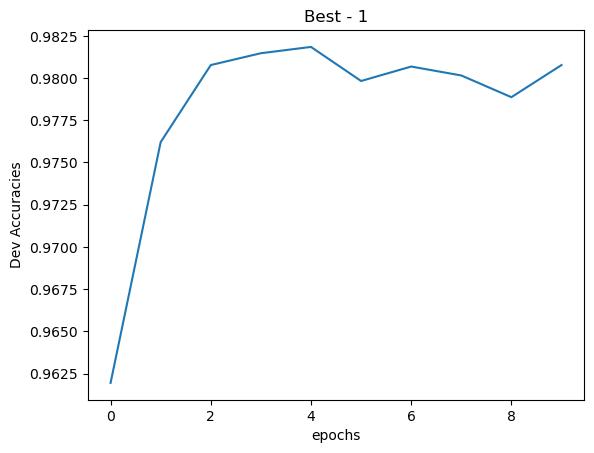

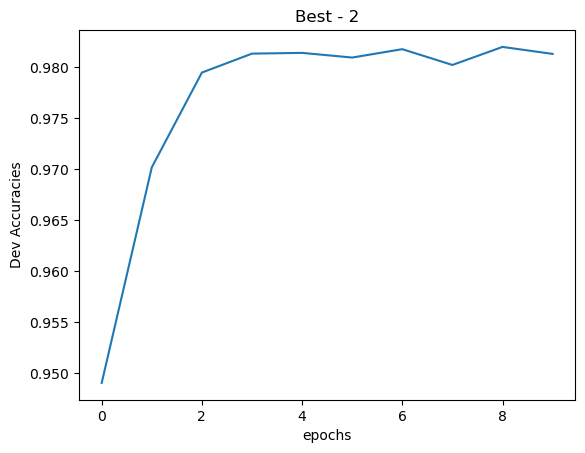

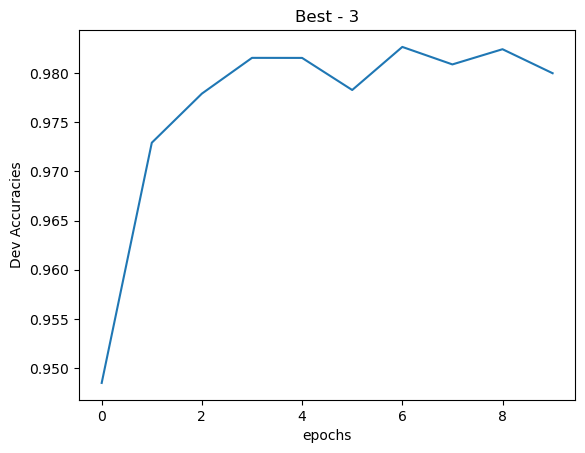

In [97]:
train_data = CustomDataset(train_sentences)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
dev_data = CustomDataset(dev_sentences)
dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)

for index in range(3):
    best = dev_performance.iloc[index]
    bidirectional = True
    model_type = best['Model']
    layers = best['Num Layers']
    hidden_dim = best['Hidden dims']
    activation = best['Activation']
    class_dim = best['Classification dim']
    if model_type == 'rnn':
        folder = 'RNN'
    elif model_type == 'gru':
        folder = 'GRU'
    else:
        folder = 'LSTM'
    model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1, activation = activation, classification_dim = class_dim, rnn_type = model_type, bidirectionality = bidirectional)
    loss_function = nn.CrossEntropyLoss(ignore_index = pos_class['<SPECIAL>'])
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    accuracies = []
    for epoch in range(num_epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            output = torch.transpose(output, 1,2)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            accuracy = 0
            for x, y in dev_loader:
                predict = model.predict(x).reshape(-1)
                y = y.reshape(-1)
                seq_index = y != pos_class['<SPECIAL>']
                y = y[seq_index]
                predict = predict[seq_index]
                accuracy += (len(predict[predict == y])) / len(predict)
        
        accuracies.append(accuracy / len(dev_loader))
    
    plt.plot(range(num_epochs), accuracies)
    plt.xlabel('epochs')
    plt.ylabel('Dev Accuracies')
    plt.title(f'Best - {index+1}')
    plt.show()

DEV: Model Type: gru, bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128
Accuracy: 0.9837, F1 Score: 0.9714, recall: 0.9837


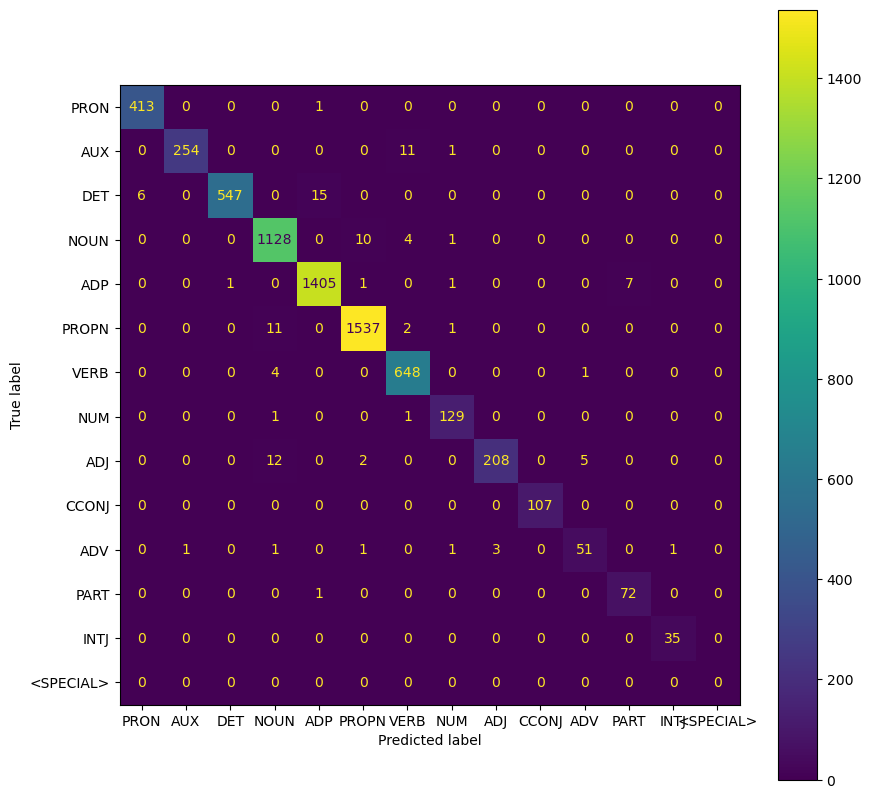

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
# dev set performances
best = dev_performance.iloc[0]
bidirectional = True
model_type = best['Model']
layers = best['Num Layers']
hidden_dim = best['Hidden dims']
activation = best['Activation']
class_dim = best['Classification dim']
model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1, activation = activation, classification_dim = class_dim, rnn_type = model_type, bidirectionality = bidirectional)
model.load_state_dict(torch.load(f'./GRU/model_{bidirectional}_{layers}_{activation}_{hidden_dim}_{class_dim}.pth'))
with torch.no_grad():
    dev_data = CustomDataset(dev_sentences)
    dev_loader = DataLoader(dev_data, batch_size=32, shuffle=False)
    predictions = torch.tensor([])
    actual = torch.tensor([])
    acc = 0
    f1 = 0
    recall = 0
    for x, y in dev_loader:
        predict = model.predict(x).reshape(-1)
        predictions = torch.cat((predictions, predict))
        actual = torch.cat((actual, y.reshape(-1)))
        
    correct_index = actual != pos_class['<SPECIAL>']
    actual = actual[correct_index]
    predictions = predictions[correct_index]
    acc = accuracy_score(actual, predictions)
    f1 = f1_score(actual, predictions, average = 'macro', zero_division = 0)
    recall = recall_score(actual, predictions, average = 'weighted', zero_division = 0)
    print(f"DEV: Model Type: {model_type}, bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim}\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}, recall: {recall:.4f}")
    actual_class = [pos_class_rev[y.item()] for y in actual]
    predictions_class = [pos_class_rev[y.item()] for y in predictions]
    cm = confusion_matrix(actual_class, predictions_class, labels = list(pos_class.keys()))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(pos_class.keys()))
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)

TEST: Model Type: gru, bidirectional: True, num_layers: 1, Activation: tanh, hidden_dim: 128, Class_dim: 128
Accuracy: 0.9863, F1 Score: 0.9665, recall: 0.9863


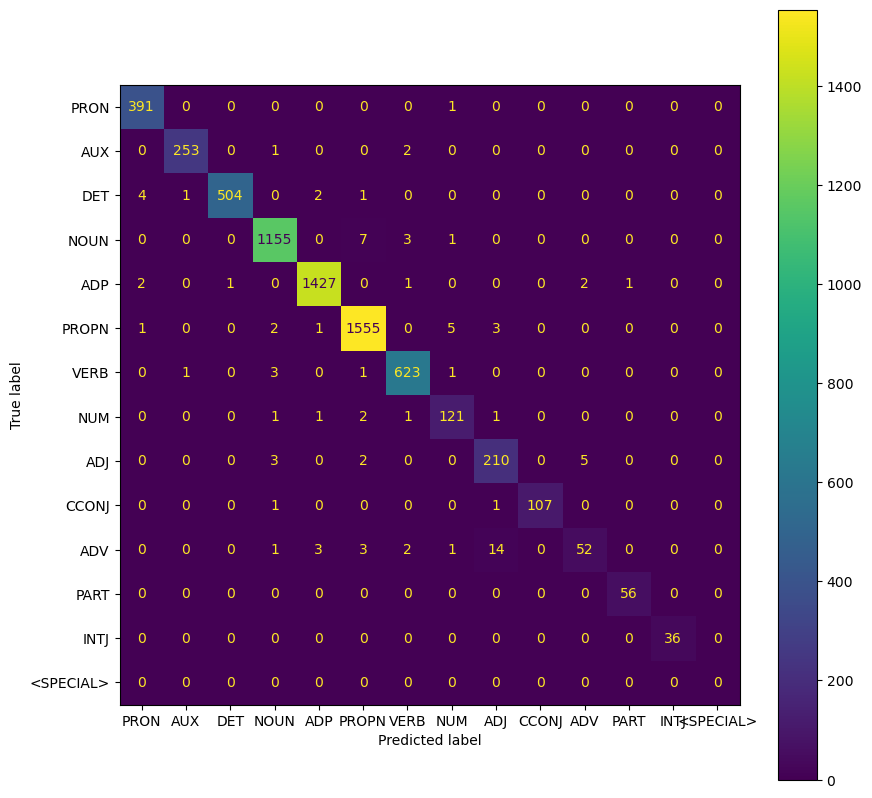

In [99]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
# test set performances
best = dev_performance.iloc[0]
bidirectional = True
model_type = best['Model']
layers = best['Num Layers']
hidden_dim = best['Hidden dims']
activation = best['Activation']
class_dim = best['Classification dim']
model = RNNModel(len(vocab), embedding_dims, layers, hidden_dim, len(pos_class)-1, activation = activation, classification_dim = class_dim, rnn_type = model_type, bidirectionality = bidirectional)
model.load_state_dict(torch.load(f'./GRU/model_{bidirectional}_{layers}_{activation}_{hidden_dim}_{class_dim}.pth'))
with torch.no_grad():
    test_data = CustomDataset(test_sentences)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    predictions = torch.tensor([])
    actual = torch.tensor([])
    acc = 0
    f1 = 0
    recall = 0
    for x, y in test_loader:
        predict = model.predict(x).reshape(-1)
#         accuracy = len(predict[predict ==  y]) / len(predict)
        predictions = torch.cat((predictions, predict))
        actual = torch.cat((actual, y.reshape(-1)))
#         acc += accuracy_score(y, predict)
#         f1 += f1_score(y, predict, average = 'macro', zero_division = 0)
#         recall += recall_score(y, predict, average = 'macro', zero_division = 0)
    correct_index = actual != pos_class['<SPECIAL>']
    actual = actual[correct_index]
    predictions = predictions[correct_index]
    acc = accuracy_score(actual, predictions)
    f1 = f1_score(actual, predictions, average = 'macro', zero_division = 0)
    recall = recall_score(actual, predictions, average = 'weighted', zero_division = 0)
    print(f"TEST: Model Type: {model_type}, bidirectional: {bidirectional}, num_layers: {layers}, Activation: {activation}, hidden_dim: {hidden_dim}, Class_dim: {class_dim}\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}, recall: {recall:.4f}")
    actual_class = [pos_class_rev[y.item()] for y in actual]
    predictions_class = [pos_class_rev[y.item()] for y in predictions]
    cm = confusion_matrix(actual_class, predictions_class, labels = list(pos_class.keys()))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = list(pos_class.keys()))
    fig, ax = plt.subplots(figsize=(10,10))
    cm_display.plot(ax=ax)

In [119]:
input_sentence = 'what is restriction ap 55'
test = tokenize(input_sentence)
predict = model.predict(test.reshape(1,-1))[0]
[pos_class_rev[pred.item()] for pred in predict][1:-1]

['PRON', 'AUX', 'NOUN', 'PROPN', 'NUM']